In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import contextily as ctx
%matplotlib inline

Load the crime data from [Kaggle](https://www.kaggle.com/c/sf-crime/data?select=train.csv.zip) extracting only the columns that we are going to use and focusing only on the training data

In [2]:
url = "https://storage.googleapis.com/kagglesdsdata/competitions/4458/34321/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1624985815&Signature=bOlvRKvfSWJDWqybh879nlslNi%2FqaCnZvhfHd4xyJt1hlqW9wVmsphybhAKwNZXRP87CbO%2F%2Bqm4%2BknwWfvv1NZCvAFIhQpwTXcVXW7JLsq0iJ4BtnfieSbo5IZuglG3WTOHkIIl%2BE%2FRpTGcIAPI2bgYZDBAJhfNW%2BYdYUg79g%2FZxPiefuPXNU7lXDVVrAHWllCI1GBzIlGj4GHz8ztgm2umc6IldFm5kwn8dLpm8Y1rWq2lbJ0ULKwJJZFAdQ8R9VHQY5%2BE0uT%2BMmDlQ%2Bgqstca8i99iKPlJZux6XKWDTepXNl7GnNzGG5SDLW7MumEUntVigm1dEegIF4XntFrB2w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip"
data = pd.read_csv(url, 
                   parse_dates=['Dates'], 
                   usecols=['Dates', 'Category', 'X', 'Y'])

We have some duplicates so we remove them.

In [3]:
data.drop_duplicates(inplace=True)

# Spatial Dependency

Quick plot to check for outliers

<AxesSubplot:xlabel='X', ylabel='Y'>

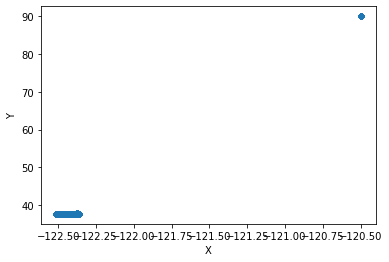

In [4]:
data.plot.scatter(x='X', y='Y')

We have a few so remove them

In [5]:
data = data[(data.X<-122) & (data.Y < 40)].copy()

Get map tiles. We use the data itself to specify the Lat/Lon limits

In [6]:
west, south, east, north = (
    data.X.min(), data.Y.min(), data.X.max(), data.Y.max()
             )

sfo_img, sfo_ext = ctx.bounds2img(west,
                                     south,
                                     east,
                                     north,
                                     ll=True,
                                    )

We plot the tiles to make sure it's all going as planned

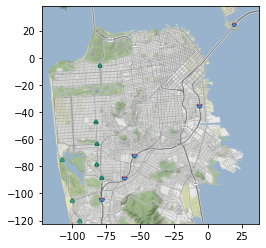

In [7]:
plt.imshow(sfo_img, extent=(west, south, east, north))

Select the categories we are interested in. For clarity we choose just a few, but we could easily plot them all in the same figure

In [8]:
categories = ['ASSAULT',
 'BURGLARY',
 'DRUG/NARCOTIC',
 'OTHER OFFENSES',
 'ROBBERY',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS']

In [9]:
data_small = data[data.Category.isin(categories)].copy()

Now we define the figure that will plot the heatmap overlayed on top of the geographical tiles

In [10]:
def plot_map(X, Y, **kwargs):
    hist, xbins, ybins = np.histogram2d(X, Y, bins=100)
    ax = plt.gca()
    ax.imshow(sfo_img, extent=(west, south, east, north))
    values = np.log10(1+hist.T[::-1])
    values[values==0] = np.nan
    ax.imshow(values, cmap=plt.cm.jet, extent=(west, south, east, north), 
              alpha=0.8)
    ax.axis('off')

We test it with the full dataset

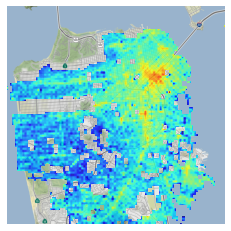

In [11]:
plot_map(data.X, data.Y)

Now we can use seaborn's FacetGrid to plot automatically slide the data by category and plot all the heatmaps

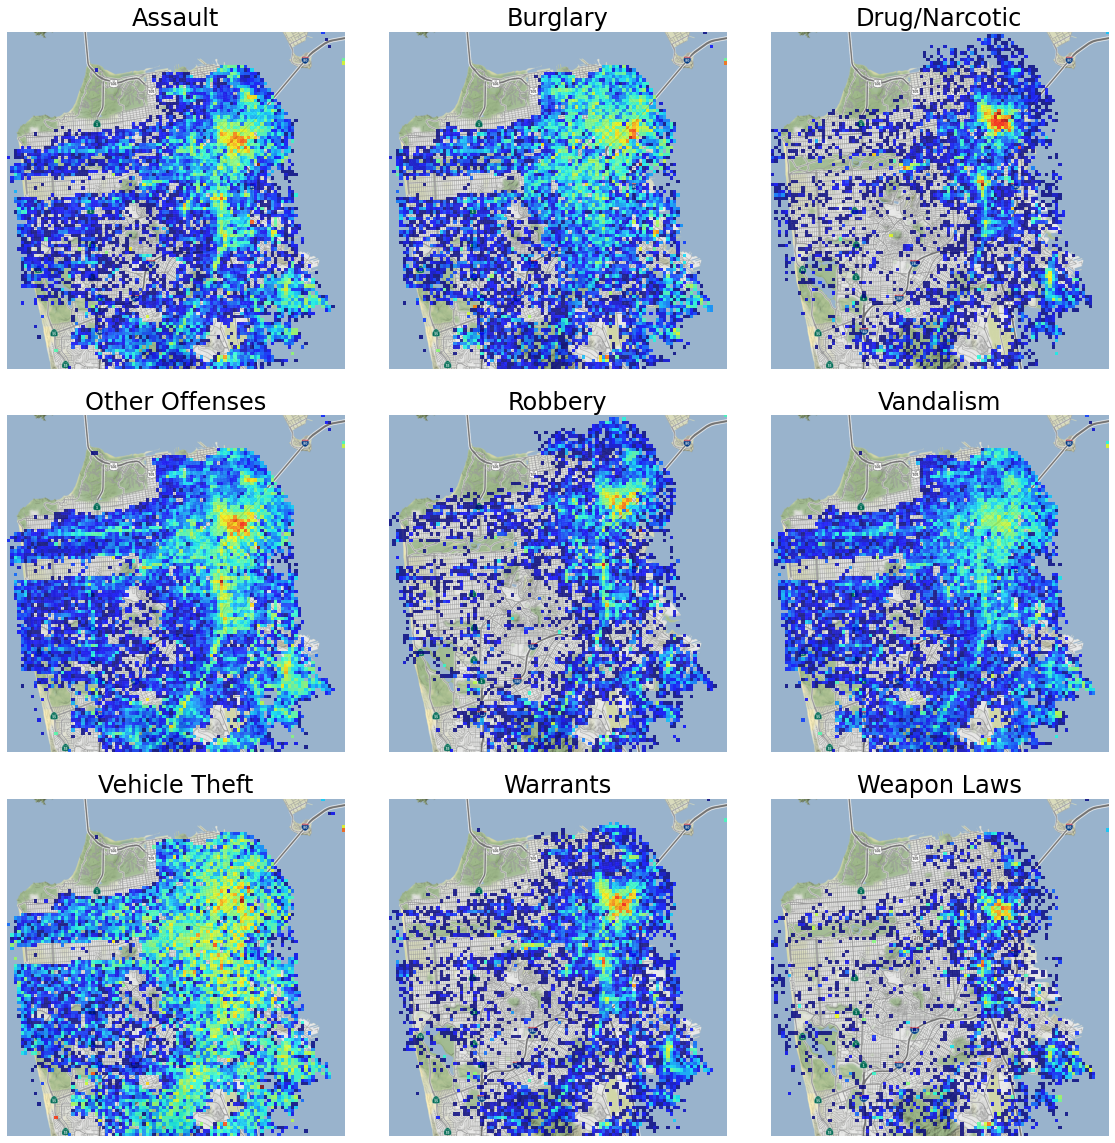

In [12]:
fg = sns.FacetGrid(data=data_small, col='Category', col_wrap=3, 
                   col_order=sorted(categories))
fg.map(plot_map, 'X', 'Y')

# clean up titles
for ax in fg.axes:
    old_title = ax.get_title()
    new_title = old_title.split('=')[1].strip().title()
    ax.set_title(new_title, fontsize=24)

fig = plt.gcf()
fig.tight_layout(pad=0.1)
fig.set_size_inches(16, 16)